In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [3]:
system = "KOI-2086"    #KOI-0156, KOI-0168, KOI-2086

data = pd.read_csv("systems/%s_data.csv"%system)
results = pd.read_csv("systems/%s_results.csv"%system)
data.columns

Index([u'Unnamed: 0', u'm1', u'T1', u'P1', u'h1', u'k1', u'm2', u'T2', u'P2',
       u'h2', u'k2', u'm3', u'T3', u'P3', u'h3', u'k3'],
      dtype='object')

## Plot data

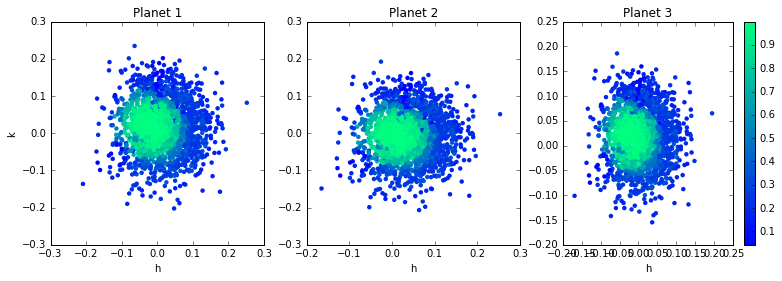

In [8]:
x = "h"
y = "k"
proba = results["predict_proba"].values

colorbar = 'winter'
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[13, 4])
ax1.scatter(data["%s1"%x][:len(proba)], data["%s1"%y][:len(proba)], c=proba, cmap=colorbar, lw=0)
ax2.scatter(data["%s2"%x][:len(proba)], data["%s2"%y][:len(proba)], c=proba, cmap=colorbar, lw=0)
c=ax3.scatter(data["%s3"%x][:len(proba)], data["%s3"%y][:len(proba)], c=proba, cmap=colorbar, lw=0)

ax1.set_ylabel(y) 
ax1.set_xlabel(x)
ax2.set_xlabel(x)
ax3.set_xlabel(x)
ax1.set_title("Planet 1")
ax2.set_title("Planet 2")
ax3.set_title("Planet 3")
cb = f.colorbar(c)
plt.savefig("images/%s_%s%s.png"%(system,x,y))

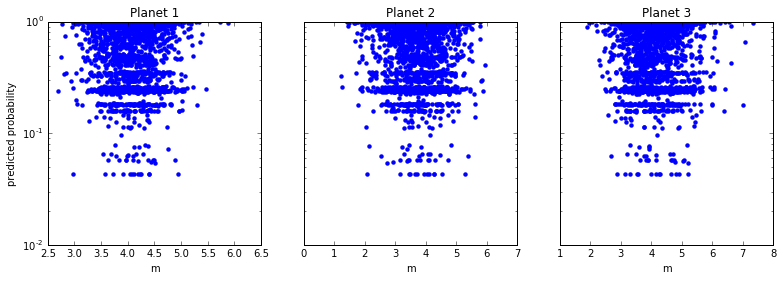

In [9]:
proba = results["predict_proba"].values

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[13, 4], sharey=True)
ax1.scatter(data["m1"][:len(proba)], proba, lw=0)
ax2.scatter(data["m2"][:len(proba)], proba, lw=0)
ax3.scatter(data["m3"][:len(proba)], proba, lw=0)

ax1.set_ylabel("predicted probability") 
ax1.set_yscale('log')
ax1.set_ylim([1e-2,1])
ax1.set_xlabel("m")
ax2.set_xlabel("m")
ax3.set_xlabel("m")
ax1.set_title("Planet 1")
ax2.set_title("Planet 2")
ax3.set_title("Planet 3")
plt.savefig("images/%s_mproba.png"%system)

## Get Nbody candidates

In [32]:
i1 = np.where((results["predict_proba"] > 0.65)&(results["predict_proba"] < 0.7))[0][0:10]
i2 = np.where((results["predict_proba"] > 0.95)&(results["predict_proba"] < 1))[0][0:10]
i3 = np.where((results["predict_proba"] > 0)&(results["predict_proba"] < 0.1))[0][0:10]
index = np.concatenate((i1,i2,i3))

In [33]:
r1 = results.iloc[index]
d1 = data.iloc[index]

In [37]:
r1.tail()

,Unnamed: 0,avg_iH1,avg_iH2,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,norm_std_a2,norm_max_a2,norm_std_window10_a2,...,min_ecross2,avg_ecross3,std_ecross3,max_ecross3,min_ecross3,norm_a1_slope,norm_a2_slope,norm_a3_slope,Lyapunov_time,predict_proba
338,338,0.0,0.0,2.910075e-08,5.813191e-08,1.767304e-08,2.898164e-08,3.687123e-08,8.485087e-08,2.820809e-08,...,1.043151,0.0,0.0,0.845568,0.845568,-4.290282e-14,5.108520e-14,-7.380208e-15,-7124.829150,0.042891
380,380,0.0,0.0,2.576972e-08,6.293042e-08,1.913273e-08,2.997888e-08,4.173360e-08,1.027615e-07,3.068129e-08,...,1.040529,0.0,0.0,0.784059,0.784058,7.198032e-14,-7.823043e-14,-6.802652e-15,-1584.015580,0.042891
473,473,0.0,0.0,1.823594e-08,4.270697e-08,1.995697e-08,3.337662e-08,2.698173e-08,5.996707e-08,2.282911e-08,...,0.679014,0.0,0.0,0.555768,0.555767,-2.065769e-14,5.445517e-14,-4.507226e-14,-6992.967862,0.064455
566,566,0.0,0.0,2.863882e-08,6.885837e-08,2.541392e-08,4.491552e-08,2.419864e-08,6.072156e-08,2.503163e-08,...,0.667593,0.0,0.0,0.524908,0.524907,2.552274e-14,-1.609055e-14,-6.937637e-15,-5449.259678,0.062206
586,586,0.0,0.0,4.331630e-08,9.698500e-08,1.612624e-08,3.526752e-08,4.251862e-08,9.939255e-08,1.733340e-08,...,0.752745,0.0,0.0,0.578632,0.578631,-1.048208e-13,3.257714e-14,3.401343e-14,-5523.080284,0.064455


In [38]:
d1.tail()

,Unnamed: 0,m1,T1,P1,h1,k1,m2,T2,P2,h2,k2,m3,T3,P3,h3,k3
338,338,4.199286,782.282999,7.133210,-0.029339,0.182081,3.699924,786.581359,8.918831,0.003094,0.144314,4.262539,780.272337,11.898236,-0.029460,0.144854
380,380,4.391661,782.280331,7.133169,0.031280,0.170240,3.937591,786.581931,8.918819,0.058391,0.131616,5.204229,780.275212,11.898168,0.014254,0.136322
473,473,3.679879,782.281500,7.133306,-0.002043,0.122552,3.886519,786.582711,8.918740,0.025916,0.090305,3.187233,780.282093,11.897833,-0.003920,0.097071
566,566,3.775478,782.286360,7.133427,0.018242,0.114233,5.384954,786.585122,8.918631,0.046378,0.079870,2.676709,780.278876,11.897863,0.007013,0.091492
586,586,3.541672,782.276240,7.133595,0.022985,0.126171,4.150019,786.580494,8.918272,0.050065,0.091283,4.614445,780.280905,11.898308,0.011322,0.100541
